In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import Xception
import re
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

In [3]:
try:
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu_resolver.master())
except ValueError:
    tpu_resolver = None

if tpu_resolver:
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
else:
    tpu_strategy = tf.distribute.get_strategy()

print("REPLICAS: ", tpu_strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
df_melanoma = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")

In [5]:
df_melanoma.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
df_melanoma.tail()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0
33125,ISIC_9999806,IP_0046310,male,45.0,torso,nevus,benign,0


In [7]:
df_melanoma.describe()

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
max,90.000000,1.000000


In [8]:
df_melanoma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


0    32542
1      584
Name: target, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

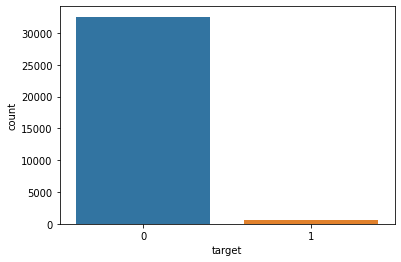

In [9]:
print(df_melanoma['target'].value_counts())
sns.countplot(df_melanoma['target'])

male      17080
female    15981
Name: sex, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sex', ylabel='count'>

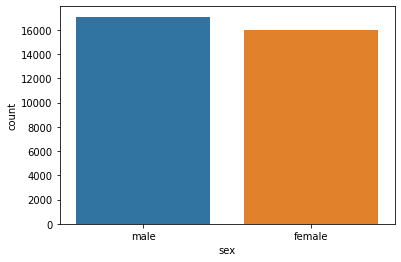

In [10]:
print(df_melanoma['sex'].value_counts())
sns.countplot(df_melanoma['sex'])

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='diagnosis', ylabel='count'>

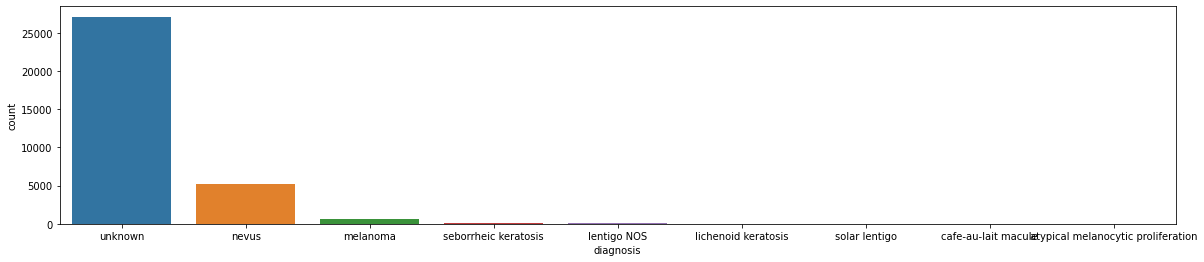

In [11]:
fig_dims = (20, 4)
fig, ax = plt.subplots(figsize=fig_dims)
print(df_melanoma['diagnosis'].value_counts())
sns.countplot(df_melanoma['diagnosis'], ax = ax)

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='anatom_site_general_challenge', ylabel='count'>

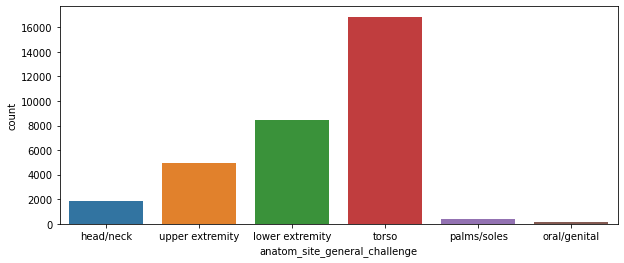

In [12]:
fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)
print(df_melanoma['anatom_site_general_challenge'].value_counts())
sns.countplot(df_melanoma['anatom_site_general_challenge'], ax = ax)

benign       32542
malignant      584
Name: benign_malignant, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='benign_malignant', ylabel='count'>

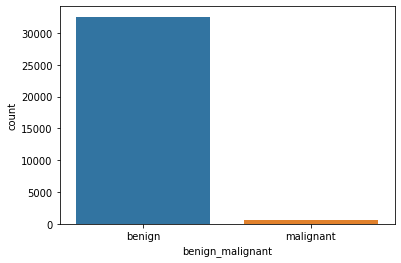

In [13]:
print(df_melanoma['benign_malignant'].value_counts())
sns.countplot(df_melanoma['benign_malignant'])

(array([2.000e+00, 1.490e+02, 2.199e+03, 5.208e+03, 3.576e+03, 8.736e+03,
        7.064e+03, 4.495e+03, 1.400e+03, 2.290e+02]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <BarContainer object of 10 artists>)

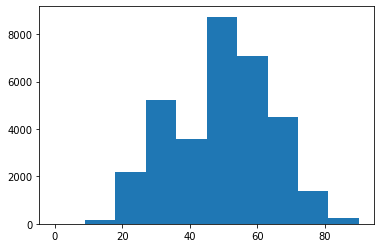

In [14]:
plt.hist(df_melanoma['age_approx'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sex', ylabel='count'>

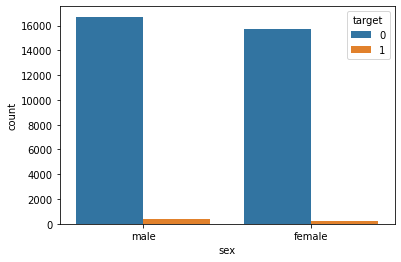

In [15]:
sns.countplot(df_melanoma['sex'], hue = df_melanoma['target'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='anatom_site_general_challenge', ylabel='count'>

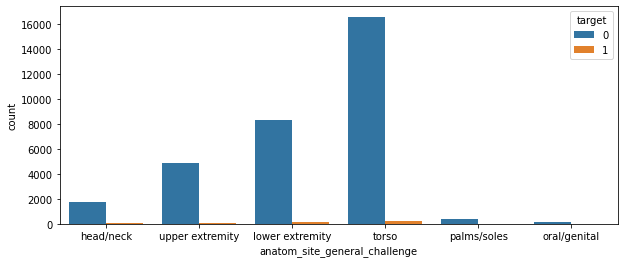

In [16]:
fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(df_melanoma['anatom_site_general_challenge'], hue = df_melanoma['target'], ax = ax)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='diagnosis', ylabel='count'>

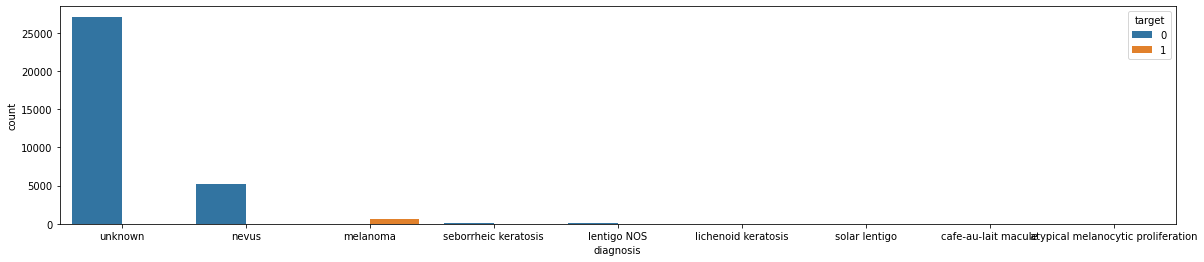

In [17]:
fig_dims = (20, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(df_melanoma['diagnosis'], hue = df_melanoma['target'], ax = ax)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age_approx', ylabel='Density'>

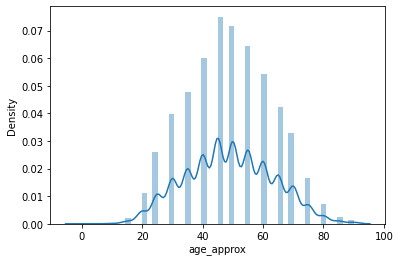

In [18]:
sns.distplot(df_melanoma['age_approx'])

In [19]:
df_melanoma.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

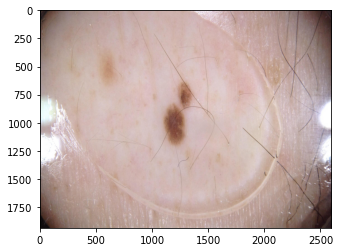

In [20]:
image = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_9999134.jpg')
plt.imshow(image)

In [21]:
autotune = tf.data.experimental.AUTOTUNE
gcs_path = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')
training_data = tf.io.gfile.glob(gcs_path + '/tfrecords/train*.tfrec')
testing_data = tf.io.gfile.glob(gcs_path + '/tfrecords/test*.tfrec')
training_data, validation_data = train_test_split(training_data, train_size = 0.8, random_state = 0)
target = [0,1]   
image_size = [1024, 1024]
batch_size = 8 * tpu_strategy.num_replicas_in_sync
epochs = 5

In [22]:
all_labels = []
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*image_size, 3])
    return image

def get_labeled_data(example):
    labeled_data = {
        "image": tf.io.FixedLenFeature([], tf.string),
       
        "target": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, labeled_data)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return image, label

def get_unlabeled_data(example):
    unlabeled_data = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, unlabeled_data)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum

def get_full_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=autotune)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(get_labeled_data if labeled else get_unlabeled_data, num_parallel_calls=autotune)
    all_labels.append(list(map(lambda x: x[1], dataset)))
    return dataset

def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_flip_up_down(image)
    return image, label   

def get_training_dataset():
    dataset = get_full_dataset(training_data, labeled=True)
    dataset = dataset.map(data_augmentation, num_parallel_calls=autotune)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(autotune)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = get_full_dataset(validation_data, labeled=True, ordered=ordered)
    dataset = dataset.map(data_augmentation, num_parallel_calls=autotune)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(autotune)
    return dataset

def get_test_dataset(ordered=False):
    dataset = get_full_dataset(testing_data, labeled=False, ordered=ordered)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(autotune)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

no_training_images = count_data_items(training_data)
no_validation_images = count_data_items(validation_data)
no_testing_images = count_data_items(testing_data)
STEPS_PER_EPOCH = no_training_images // batch_size
print('Dataset: {} training images, {} validation images and {} unlabeled test images'.format(no_training_images,no_validation_images, no_testing_images))

Dataset: 24842 training images, 8284 validation images and 10982 unlabeled test images


In [23]:
validation_ds = get_validation_dataset()
true_labels = all_labels
print(len(true_labels))
print(len(true_labels[0]))

1
8284


In [24]:
def custom_learning_function(start_learning_rate=0.00001, max_learning_rate=0.0001, 
               min_learning_rate=0.000001, learning_rate_rampup_epochs=20, 
               learning_rate_sustain_epochs=0, learning_rate_exp_decay=.8):
    max_learning_rate = max_learning_rate * tpu_strategy.num_replicas_in_sync

    def learning_rate_function(epoch):
        if epoch < learning_rate_rampup_epochs:
            learning_rate = (max_learning_rate - start_learning_rate) / learning_rate_rampup_epochs * epoch + start_learning_rate
        elif epoch < learning_rate_rampup_epochs + learning_rate_sustain_epochs:
            learning_rate = max_learning_rate
        else:
            learning_rate = (max_learning_rate - min_learning_rate) * learning_rate_exp_decay**(epoch - learning_rate_rampup_epochs - learning_rate_sustain_epochs) + min_learning_rate
        return learning_rate
    
    return learning_rate_function

In [25]:
with tpu_strategy.scope():
    xception_model = tf.keras.Sequential([
        Xception(
            input_shape=(*image_size, 3),
            weights='imagenet',
            include_top=False
        ),
        tf.keras.layers.GlobalAveragePooling2D(), 
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

83689472/83683744 [==============================] - 1s 0us/step


In [26]:
def custom_focal_loss_function(gamma=2., alpha=.25):
	def focal_loss_function(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_function

In [27]:
xception_model.compile(
    optimizer='adam',
#     loss = tf.keras.losses.BinaryCrossentropy(),
    loss = custom_focal_loss_function(gamma=2., alpha=.25),
    metrics=['binary_crossentropy', 'accuracy']
)
xception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 32, 32, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [28]:
learning_rate = custom_learning_function()
learning_rate_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate, verbose=1)

In [29]:
train=pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
from sklearn.utils.class_weight import compute_class_weight
cw=compute_class_weight('balanced',np.unique(train['target']),train['target'])
cw_dict={0:cw[0],1:cw[1]}

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=0        0
1        0
2        0
3        0
4        0
        ..
33121    0
33122    0
33123    0
33124    0
33125    0
Name: target, Length: 33126, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [30]:
history = xception_model.fit(
    get_training_dataset(), 
    epochs=epochs, 
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[learning_rate_schedule],
    validation_data = get_validation_dataset(),
    class_weight = {0:0.50899675,1: 28.28782609}
)

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
388/388 [==============================] - 354s 795ms/step - loss: 0.0468 - binary_crossentropy: 0.3877 - accuracy: 0.9655 - val_loss: nan - val_binary_crossentropy: 0.2039 - val_accuracy: 0.9826
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 4.95e-05.
388/388 [==============================] - 297s 765ms/step - loss: 0.0201 - binary_crossentropy: 0.2103 - accuracy: 0.9829 - val_loss: nan - val_binary_crossentropy: 0.2606 - val_accuracy: 0.9827
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 8.9e-05.
388/388 [==============================] - 294s 758ms/step - loss: 0.0191 - binary_crossentropy: 0.1989 - accuracy: 0.9829 - val_loss: nan - val_binary_crossentropy: 0.2165 - val_accuracy: 0.9825
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001285.
388/388 [==============================] - 294s 759ms/step - loss: 0.0189 - binary_cros

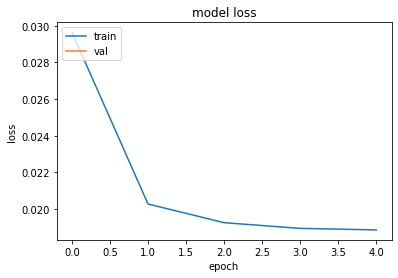

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

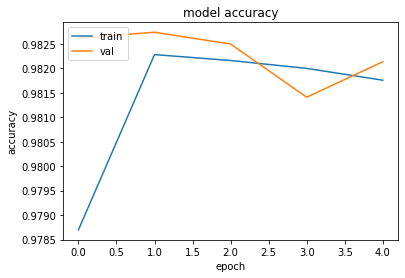

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
xception_model.save('final_xception_model.h5')

In [34]:
xception_model.save_weights('final_xception_model_weights.h5')

In [35]:
validation_images = validation_ds.map(lambda image, target: image)
y_pred = xception_model.predict(validation_images)
for i in range(len(y_pred)):
    y_pred[i] = round(float(y_pred[i]), 0)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(true_labels[0],y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8140
           1       0.00      0.00      0.00       144

    accuracy                           0.98      8284
   macro avg       0.49      0.50      0.50      8284
weighted avg       0.97      0.98      0.97      8284



In [37]:
test_ds = get_test_dataset(ordered=True)
test_images_ds = test_ds.map(lambda image, idnum: image)

In [38]:
probabilities = xception_model.predict(test_images_ds)

In [39]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(no_testing_images))).numpy().astype('U') # all in one batch

Generating submission.csv file...


In [40]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

,image_name,target
0,ISIC_6381819,0.289039
1,ISIC_5583376,0.212873
2,ISIC_6408546,0.083804
3,ISIC_6932354,0.402398
4,ISIC_8191278,0.233900


In [41]:
sub = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv")
sub

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0
...,...,...
10977,ISIC_9992485,0
10978,ISIC_9996992,0
10979,ISIC_9997917,0
10980,ISIC_9998234,0


In [42]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
sub.to_csv('complete_data.csv', index=False)
sub.head()

,image_name,target
0,ISIC_0052060,0.129390
1,ISIC_0052349,0.078159
2,ISIC_0058510,0.044562
3,ISIC_0073313,0.055461
4,ISIC_0073502,0.248482
